In [1]:
import torch 
import numpy as np 
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv('reviews.csv')

In [3]:
df.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOH5OkwJH-nRT4nopD_JNTIYpWs1xWzOsFE-pn7...,Charles Green,https://play-lh.googleusercontent.com/a-/AOh14...,"Ugh! After years of using this app, I am so ve...",1,3,5.9.0.2,2021-02-10 16:21:44,"90% of the app is completely free, including a...",2021-02-11 09:29:42,most_relevant,com.anydo
1,gp:AOqpTOH2VEhd1ldAR1zxGzjJEIa37fCBgY9S3sqe_TE...,Matt Van Der Schyff,https://play-lh.googleusercontent.com/-sMd4wLr...,originally gave this a 2 star but I think it o...,1,72,5.9.0.2,2021-02-04 05:35:28,We are unaware of any issues with setting remi...,2021-02-04 09:08:06,most_relevant,com.anydo
2,gp:AOqpTOFZ-MWENdh24H_g0qGDAVUkrdFEJoNaYudcwe2...,Don White,https://play-lh.googleusercontent.com/-3dOQZya...,"January 2021: In short..I'm done, and moving o...",1,186,5.7.0.20,2021-01-15 14:25:27,We're are doing our best to fix any issues and...,2021-01-18 14:11:54,most_relevant,com.anydo


/home/imagedpt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='score', ylabel='count'>

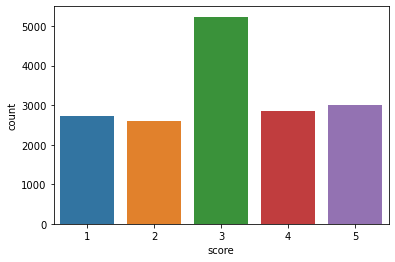

In [4]:
sns.countplot(df.score)

### Convert the scores into negative, neutral and positive sentiments

In [5]:
def sentiment(rating) : 
    if (rating == 1 )|(rating == 2) : 
        return 0 
    elif (rating == 3) : 
        return 1 
    elif (rating >= 4) : 
        return 2 
    

In [6]:
df['sentiment'] = df.score.apply(sentiment)

In [7]:
df.head(2)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,gp:AOqpTOH5OkwJH-nRT4nopD_JNTIYpWs1xWzOsFE-pn7...,Charles Green,https://play-lh.googleusercontent.com/a-/AOh14...,"Ugh! After years of using this app, I am so ve...",1,3,5.9.0.2,2021-02-10 16:21:44,"90% of the app is completely free, including a...",2021-02-11 09:29:42,most_relevant,com.anydo,0
1,gp:AOqpTOH2VEhd1ldAR1zxGzjJEIa37fCBgY9S3sqe_TE...,Matt Van Der Schyff,https://play-lh.googleusercontent.com/-sMd4wLr...,originally gave this a 2 star but I think it o...,1,72,5.9.0.2,2021-02-04 05:35:28,We are unaware of any issues with setting remi...,2021-02-04 09:08:06,most_relevant,com.anydo,0


In [8]:
df.to_csv('reviews1.csv', index = False)

In [9]:
d = pd.read_csv('reviews1.csv')

/home/imagedpt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

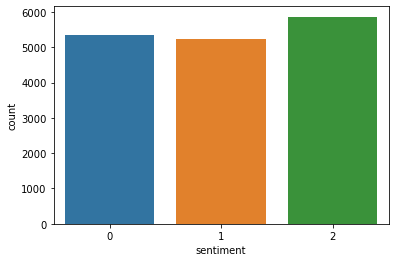

In [10]:
sns.countplot(df.sentiment)
#0: negative
#1 : neutral
#2: positive

### Pre-processing to use BERT LM fine tuned to text classification 

##### Some examples: 

In [11]:
print(tokenizer.sep_token , tokenizer.sep_token_id)
print(tokenizer.cls_token , tokenizer.cls_token_id)
print(tokenizer.pad_token , tokenizer.pad_token_id)

NameError: name 'tokenizer' is not defined

###### Encoding

### How to choose the length of the sequence ?

In [12]:
tokens_length = []
for content in df.content : 
    tokens = tokenizer.tokenize(content)
    tokens_length.append(len(tokens))
    
    

NameError: name 'tokenizer' is not defined

In [13]:
from transformers import BertTokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

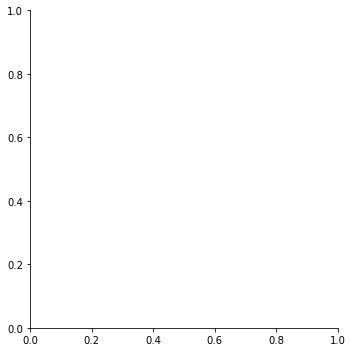

In [14]:
sns.displot(tokens_length)

In [62]:
import  torch.nn.functional as F
import torch
from torch import nn
from transformers import BertModel 

class NeuralNet(nn.Module):
    def __init__(self
                 ,n_filters, 
                 filter_sizes, 
                 output_dim, 
                 dropout):
        
        super(NeuralNet, self).__init__()
        
        
        
        self.bert = BertModel.from_pretrained('bert-base-cased' )
        
        embedding_dim = self.bert.config.hidden_size
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_ids, attention_mask ):
        
        outputs , pooled_output = self.bert(

        input_ids=input_ids,

        attention_mask=attention_mask , return_dict=False )

        #output = self.drop(pooled_output)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = outputs.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [63]:
N_FILTERS = 100
FILTER_SIZES = [2,3,4]
OUTPUT_DIM = 3
DROPOUT = 0.5


In [69]:
model = NeuralNet(N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT ).to(device)

NameError: name 'device' is not defined

In [65]:
model

NeuralNet(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [66]:
o = model(data['input_ids'] , data['attention_mask'])

In [67]:
o

tensor([[ 0.0278, -0.8858,  0.2483],
        [ 0.0957, -1.1293,  0.7377],
        [ 0.2427, -0.9011, -0.0612],
        [ 0.0876, -1.5888,  0.0224],
        [ 0.0720, -0.8853, -0.1656],
        [ 0.0357, -0.6106,  0.1440],
        [-0.0084, -1.6168,  0.2699],
        [ 0.5370, -0.3654, -0.0395]], grad_fn=<AddmmBackward>)

In [68]:
model

NeuralNet(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [40]:
outputs = model.bert(data['input_ids'] , data['attention_mask'])

In [49]:
outputs[0].size()

torch.Size([8, 160, 768])

In [51]:
outputs[0].unsqueeze(1).size()

torch.Size([8, 1, 160, 768])

In [32]:
model = CnnTextClassifier(3)

##### ==> we can see that we have the distribution between 0 and 128 length so we are going to choose 128as a max length

## Create DataSet

In [24]:
from torch.utils.data import Dataset , DataLoader
class Sentiment_analysis (Dataset) : 
    
    def __init__(self, reviews, targets, tokenizer, max_len):

        self.reviews = reviews

        self.targets = targets

        self.tokenizer = tokenizer

        self.max_len = max_len

    def __len__(self):

        return len(self.reviews)

    def __getitem__(self, item):

        review = str(self.reviews[item])

        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(

          review,

          add_special_tokens=True,

          max_length=self.max_len,

          return_token_type_ids=False,

          pad_to_max_length=True,

          return_attention_mask=True,

          return_tensors='pt',

        )

        return {'review_text': review,

          'input_ids': encoding['input_ids'].flatten(),

          'attention_mask': encoding['attention_mask'].flatten(),

          'targets': torch.tensor(target, dtype=torch.long)

    }
        
    


In [25]:
c = Sentiment_analysis(df.content , df.sentiment , tokenizer , 128)

In [26]:
c

In [27]:
max_length = 160 
batch_size = 8 
epochs = 1

In [28]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    
    ds = Sentiment_analysis(

        reviews=df.content.to_numpy(),

        targets=df.sentiment.to_numpy(),

        tokenizer=tokenizer,

        max_len=max_len)
        
    return DataLoader(ds,batch_size=batch_size,num_workers=4)

In [29]:
data_train , data_test ,  = train_test_split(df , test_size = 0.2 )

In [30]:
train_data_loader =  create_data_loader(data_train , tokenizer , max_length , batch_size)
test_data_loader =  create_data_loader(data_test , tokenizer , max_length , batch_size)

In [31]:
print(train_data_loader)

In [32]:
data = next(iter(train_data_loader))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/imagedpt/anaconda3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2149: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to 

In [25]:
data['input_ids'].shape

torch.Size([8, 160])

### Start building a classifier with bert

In [ ]:
from transformers import BertModel , BertForPreTraining
from torch import nn
import  torch.nn.functional as F


In [58]:
class sentiment_classifier(nn.Module) :
    def __init__(self, n_classes):

        super(sentiment_classifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased' )

        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask ):
        
        _, pooled_output = self.bert(

        input_ids=input_ids,

        attention_mask=attention_mask , return_dict=False )

        output = self.drop(pooled_output)

        return self.out(output)
    
    def save (self, path) : 
        torch.save(self, path)

In [59]:
model = sentiment_classifier(3)

In [61]:
model.bert.config.hidden_size

768

In [ ]:
model

In [ ]:
input_ids = data['input_ids']
attention_mask = data['attention_mask']
model.train()

In [ ]:
outputs = model(input_ids = input_ids , attention_mask = attention_mask)
preds_prob = torch.max(outputs , dim = 1)

In [ ]:
target = data['targets']

In [ ]:
torch.max(outputs , dim = -1)[1]

In [ ]:
_ , preds =  torch.max(outputs , dim = 1)

In [ ]:
preds

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
loss_fn(outputs , target)

#### Visualize our classifiers' layers

In [ ]:
data.keys()

In [ ]:
from torch import nn
import  torch.nn.functional as F
outputs = F.softmax(model(input_ids, attention_mask))


### Training : 

In [ ]:
EPOCHS = 2
from torch.optim import AdamW
from  transformers import get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

In [ ]:
model.train()

In [ ]:
input_ids

In [ ]:
def train_epoch(
    model,
    train_data_loader, 
    loss, 
    scheduler, 
    n_exemples
    
) : 
    losses = [] 
    correct_predictions = 0
    model.train() 
    for  d in train_data_loader : 
        input_ids = d['input_ids'] 
        attention_mask = d['attention_mask']
        targets = d['targets']
        outputs = model( input_ids = input_ids , 
                       attention_mask = attention_mask) 
        _ , preds =  torch.max(outputs , dim = 1) 
        loss = loss_fn(outputs , targets )
        losses.append(loss.item()) 
        correct_predictions += torch.sum(targets== preds)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        
    return correct_predictions/n_exemples , np.mean(losses)

In [ ]:
len(data)

In [ ]:
train_epoch(model , data , loss_fn , scheduler , len(data))

In [ ]:
def eval_model( model, 
              dataloader , 
              loss_fn , 
              n_exemple) : 
    model.eval() 
    correct_prediciton = 0 
    
    for d in train_data_loader : 
        input_ids = d['input_ids'] 
        attention_mask = d['attention_mask']
        targets = d['targets']
        outputs = model( input_ids = input_ids , 
                       attention_mask = attention_mask) 
        _ , preds =  torch.max(outputs , dim = 1) 
        loss = loss_fn(outputs , targets )
        losses.append(loss.item()) 
        correct_predictions += torch.sum(targets== preds)
        
    return correct_predictions.double()/n_exemple , np.mean(losses)
        

In [ ]:
from collections import defaultdict
history = defaultdict(list)

best_accuracy = 0
for epoch in range (EPOCHS) : 
    train_acc, train_loss = train_epoch(

    model,

    train_data_loader,

    loss_fn,

    optimizer,

    scheduler,

    len(train_data_loader) )
    
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, text_loss = eval_model(

    model,

    test_data_loader,

    loss_fn,

    len(df_test)
  )

    print(f'Val   loss {val_loss} accuracy {val_acc}')

    print()

    history['train_acc'].append(train_acc)

    history['train_loss'].append(train_loss)

    history['val_acc'].append(val_acc)

    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:

        torch.save(model.state_dict(), 'best_model_state.bin')

        best_accuracy = val_acc

In [ ]:
from torch import nn 
from transformers import BertModel , BertTokenizer

class sentiment_analysis (nn.Module) : 

    def __init__(self, name_model,  n_class) : 
        super(sentiment_analysis, self).__init__()
        self.name_model = name_model
        self.bert = BertModel.from_pretrained(self.name_model)
        self.drop = nn.Dropout(p=0.3) 
        self.linear = nn.Linear(self.bert.config.hidden_size, n_class)

    def forward (self , input_ids, attention_mask) : 
        _ , pooled  = self.bert(input_ids  = input_ids , 
                                attention_mask = attention_mask, 
                                return_dict=False)
        output = self.drop(pooled) 
        out = self.linear(output)
        return out
    
    def save (self, path) : 
        self.save(path)

    def load_tokenizer (self) : 
        tokenizer = BertTokenizer.from_pretrained(self.name_model)
        return tokenizer


    def predict (self , input_ids , attention_mask) : 
        self.eval()
        preds = torch.max(self (input_ids = input_ids , attention_mask = attention_mask)[1] , dim = -1 ) 
        return preds

In [ ]:
model = sentiment_analysis ('bert-base-cased', 3)

In [ ]:
pred = model.predict(input_ids = input_ids , attention_mask= attention_mask )

In [ ]:
pred[1]

In [ ]:
targets = data['targets']

In [ ]:
targets.shape

In [ ]:
input_ids.shape

In [ ]:
loss = nn.CrossEntropyLoss()

In [ ]:
p = model (input_ids = input_ids , attention_mask = attention_mask)

In [ ]:
loss(p , targets)

In [ ]:
import torch 
d = torch.tensor([1,1.6,99])
torch.zeros(3).add(d)

In [ ]:
d/2

### Evaluation 

In [ ]:
def get_predictions (model, dataloader) : 
    review_text = list()
    predictions = list() 
    prediction_prob = [] 
    targets_list = []
    for d in dataloader : 
        text = d['review_text']
        input_ids = d['input_ids']
        attention_mask = d['attention_mask']
        targets = d['targets']
        outputs  = model( input_ids =  input_ids , attention_mask = attention_mask)
        _, preds  = torch.max( outputs , dim =1 ) 
        
        review_text.extend(text) 
        targets_list.extend(targets)
        _, pred = torch.max(outputs , dim = 1) 
        predictions.extend(preds) 
        prediction_prob.extend(outputs)
        
    predictions = torch.stack(predictions) 
    prediction_prob = torch.stack(prediction_prob)
    targets_list = torch.stack(targets_list)
    review_text = torch.stack(review_text)
    return predictions, targets_list , review_text


###  Get model : 

In [ ]:
model = sentiment_classifier(3)
model.save_pretrained('m')     

In [ ]:
test_acc , test_loss = eval_model(model , test_data_loader , loss_fn , len(data_test))

In [ ]:
predictions, targets_list , review_text = get_predictions(model , test_data_loader )